In [183]:
''' ALL IMPORTS '''
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

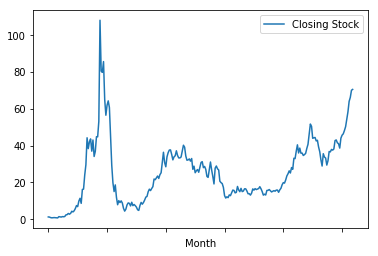

In [184]:
data = pd.read_csv('stock_data.csv') #Sample Dataset
data = data[['Month','Closing Stock']] #Filtered only 2 columns for this Analysis
data.plot(x = 'Month', y = 'Closing Stock') #Checking how the trend looks like

In [185]:
data['Month']=pd.to_datetime(data['Month']) #Converting month column into time series object
data.set_index('Month', inplace=True)

In [186]:
ts = data['Closing Stock'] #converting to time series

In [187]:
''' Check Stationarity '''

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plotting rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Performing Dickey-Fuller test:
    print('Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

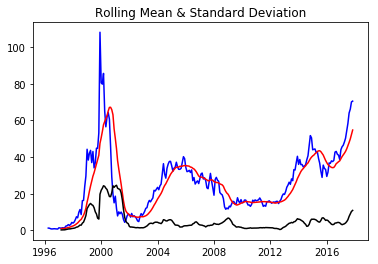

Dickey-Fuller Test:
Test Statistic                  -2.611415
p-value                          0.090661
#Lags Used                      11.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [188]:
test_stationarity(ts)
#p value is greater than 0.5, so non - stationary

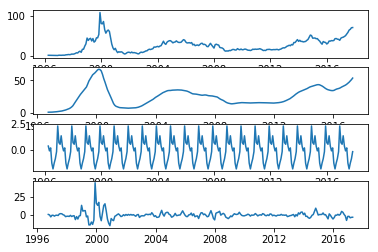

In [189]:
#Using Decomposition to remove trend and seasonality 

decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts,label = 'Original')
plt.subplot(412)
plt.plot(trend,label = 'Trend')
plt.subplot(413)
plt.plot(seasonal,label = 'Seasonal')
plt.subplot(414)
plt.plot(residual,label = 'Residual')

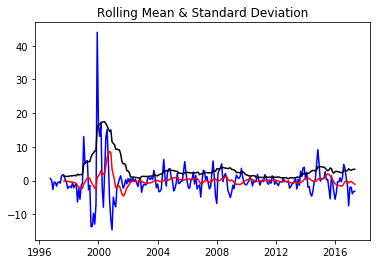

Dickey-Fuller Test:
Test Statistic                  -5.045046
p-value                          0.000018
#Lags Used                      14.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


In [190]:
# #Checking for stationarity in residual
ts_decompose = residual.dropna()
test_stationarity(ts_decompose)
#Test Statistic is now less than even 1% critical value

In [191]:
#Splitting data into train and test sample
train_data, test_data = ts_decompose[3:int(len(ts_decompose)*0.9)], ts_decompose[int(len(ts_decompose)*0.9):]

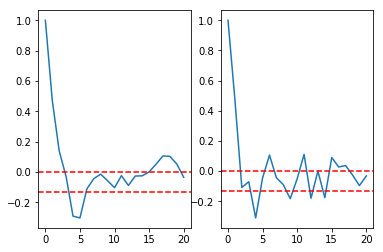

In [192]:
#Using ARIMA model and determining values for parameters p and q

ts_acf = acf(train_data,nlags=20) #Autocorrelation Function
ts_pacf = pacf(train_data,nlags=20) #Partial Autocorrelation Function

plt.subplot(121)
plt.plot(ts_acf)
plt.axhline(y=0,color='red',linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(train_data)),color='red',linestyle='--')

# q = 3 as first time acf crosses red line (Confidence Interval) is at ~3

plt.subplot(122)
plt.plot(ts_pacf)
plt.axhline(y=0,color='red',linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(train_data)),color='red',linestyle='--')

# p = 2 as first time pacf crosses red line (Confidence Interval) is at ~2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


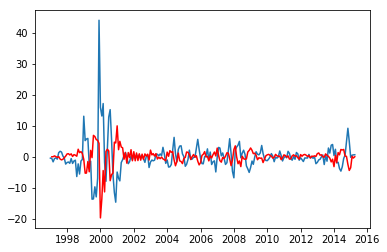

In [193]:
model = ARIMA(train_data,order = (3,1,2))
results = model.fit(disp=-1)
plt.plot(train_data)
plt.plot(results.fittedvalues,color='red')

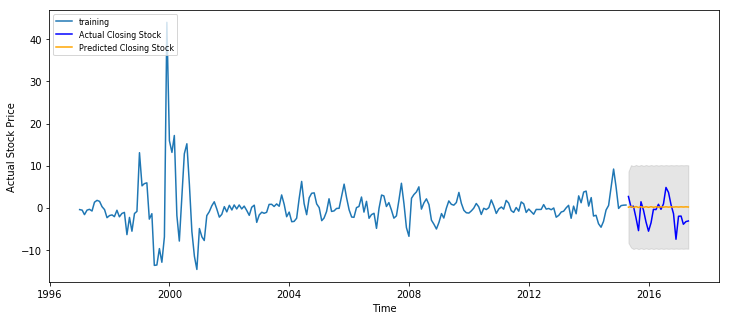

In [200]:
# Forecast
fc, se, conf = results.forecast(25, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)


lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5))
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Closing Stock')
plt.plot(fc_series, color = 'orange',label='Predicted Closing Stock')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()